# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Modeling Reddit

In [2]:
reddit = pd.read_csv('https://github.com/hemanth07mit/ml-project/blob/main/data/reddit_combined_data.csv?raw=true')

In [3]:
reddit.head()

,state,reddit_neg,reddit_neu,reddit_pos,reddit_compound,text,dum_reopening,dum_stay_home,dum_gatherings,dum_restaurants,dum_bars,dum_masks,dum_emergency_declaration,death_tot,hosp_tot,pos_tot,test_tot,pos_test_rate,pos_or_neg_sent
0,alabama,0.125,0.626,0.249,0.2927,"After public apology, Montgomery councilman’s ...",0,1,1,1,1,1,1,630,7752,49678,282815,0.1757,pos
1,alabama,0.000,1.000,0.000,0.0000,University of Alabama graduate tells his COVID...,0,1,1,1,1,1,1,630,7752,49678,282815,0.1757,pos
2,alabama,0.000,0.805,0.195,0.1779,Tuscaloosa adopts face mask law for public spaces,0,1,1,1,1,1,1,630,7752,49678,282815,0.1757,pos
3,alabama,0.146,0.657,0.197,0.1779,Coin shortage due to coronavirus: What’s happe...,0,1,1,1,1,1,1,630,7752,49678,282815,0.1757,pos
4,alabama,0.000,1.000,0.000,0.0000,[Study Results] How is Coronavirus Pandemic Af...,0,1,1,1,1,1,1,630,7752,49678,282815,0.1757,pos


In [4]:
reddit.set_index('state', inplace = True)

In [5]:
reddit.shape

(9841, 18)

In [6]:
X = reddit.drop(columns = ['reddit_compound', 'text', 'pos_or_neg_sent', 'reddit_neg', 'reddit_pos'])
y = reddit['pos_or_neg_sent']

In [7]:
y.value_counts(normalize=True)

pos    0.544863
neg    0.455137
Name: pos_or_neg_sent, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3000, stratify = y)

In [9]:
ss = StandardScaler()

Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

## Logistic Regression with Reddit Data

In [10]:
logreg_r = LogisticRegression()

logreg_r.fit(Z_train, y_train)

LogisticRegression()

In [11]:
print(logreg_r.score(Z_train, y_train))
print(logreg_r.score(Z_test, y_test))

0.5634146341463414
0.5505891913856156


In [12]:
preds_logreg_r = logreg_r.predict(Z_test)

In [16]:
# Code adapted from global lect: Classification Metrics II

pred_proba_r = [i[1] for i in logreg_r.predict_proba(Z_test)]

pred_df_r = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_r})

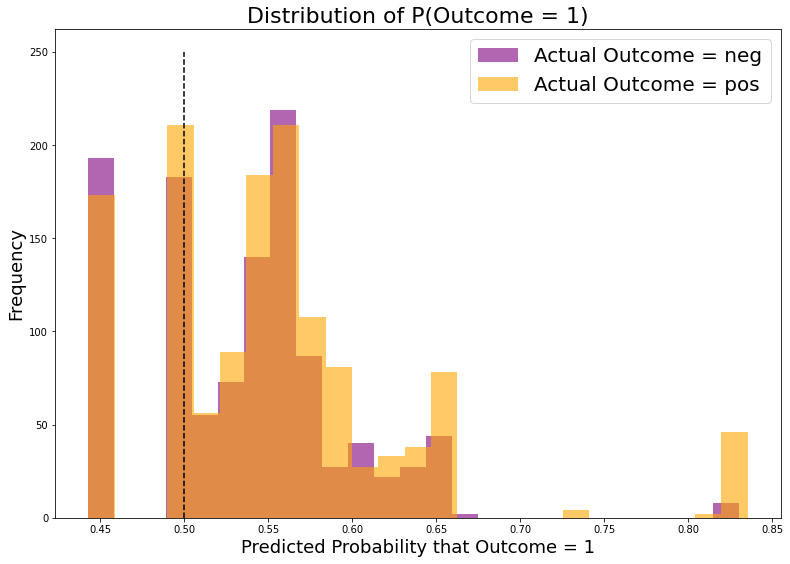

In [17]:
# Code adapted from global lect: Classification Metrics II

# Create figure.
plt.figure(figsize = (13,9))

# Create two histograms of observations.
plt.hist(pred_df_r[pred_df_r['true_values'] == 'neg']['pred_probs'],
         bins=25,
         color='purple',
         alpha = 0.6,
         label='Actual Outcome = neg')
plt.hist(pred_df_r[pred_df_r['true_values'] == 'pos']['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = pos')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 250,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

## RandomForest Classifier with Reddit Data

In [18]:
params_rf_r = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 4, 6]
}

grid_rf_r = GridSearchCV(RandomForestClassifier(),
                        params_rf_r,
                        cv = 5,
                        verbose = 1)


In [19]:
grid_rf_r.fit(Z_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [20]:
grid_rf_r.best_params_

{'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 200}

In [21]:
grid_rf_r.score(Z_train, y_train), grid_rf_r.score(Z_test, y_test)

(0.6176151761517615, 0.5676554246241365)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix Predicting\nPositive or Negative Sentiment')

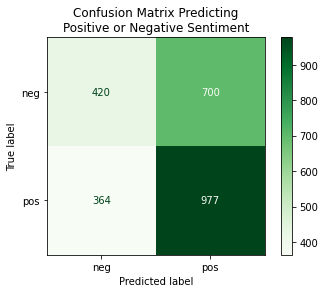

In [22]:
plot_confusion_matrix(grid_rf_r, Z_test, y_test, cmap = 'Greens', values_format = 'd');
plt.title("Confusion Matrix Predicting\nPositive or Negative Sentiment", fontsize=12)

In [ ]:
# Code adapted from global lect: Classification Metrics II

pred_proba_rf_r = [i[1] for i in grid_rf_r.predict_proba(Z_test)]

pred_df_rf_r = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_rf_r})

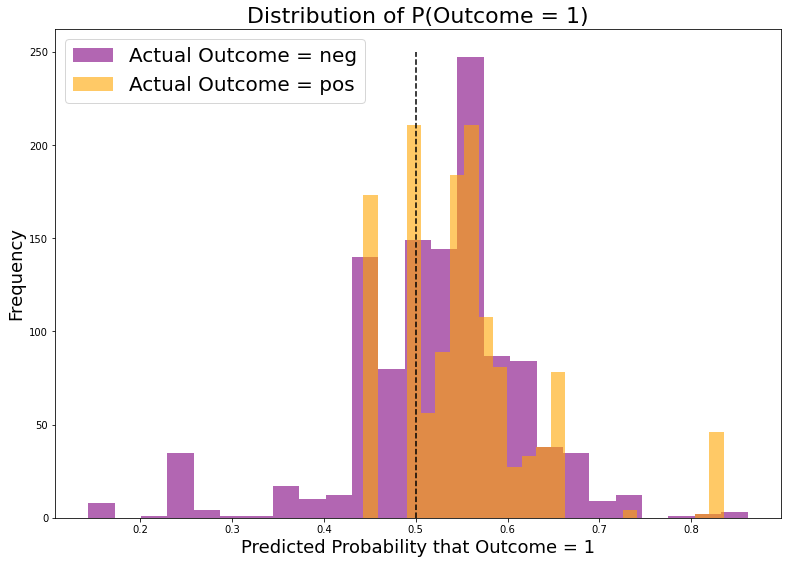

In [ ]:
# Code adapted from global lect: Classification Metrics II

# Create figure.
plt.figure(figsize = (13,9))

# Create two histograms of observations.
plt.hist(pred_df_rf_r[pred_df_rf_r['true_values'] == 'neg']['pred_probs'],
         bins=25,
         color='purple',
         alpha = 0.6,
         label='Actual Outcome = neg')
plt.hist(pred_df_r[pred_df_r['true_values'] == 'pos']['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = pos')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 250,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

## Predicting Death Totals with Reddit Data

### Linear Regression Reddit

In [ ]:
X2 = reddit.drop(columns = ['text', 'death_tot', 'pos_or_neg_sent'])
y2 = reddit['death_tot']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 3000)

In [ ]:
ss2 = StandardScaler()

Z_train2 = ss2.fit_transform(X_train2)
Z_test2 = ss2.transform(X_test2)

In [ ]:
linreg = LinearRegression()

linreg.fit(Z_train2, y_train2)

LinearRegression()

In [ ]:
linreg.score(Z_train2, y_train2), linreg.score(Z_test2, y_test2)

(0.9813217161211529, 0.9806115308348724)

> Linear regression was used to predict the death totals from each post using sentiment scores, policy data, and other health data like the number of tests positive as features. With this data, the model was able to predict death totals with an R^2 score of 0.98.

# Modeling Twitter

In [ ]:
twitter = pd.read_csv('https://github.com/hemanth07mit/ml-project/blob/main/data/tweets_combined_data.csv?raw=true')

In [ ]:
twitter.set_index('state', inplace = True)

In [ ]:
twitter.head()

,twitter_neg,twitter_neu,twitter_pos,twitter_compound,text,dum_reopening,dum_stay_home,dum_gatherings,dum_restaurants,dum_bars,dum_masks,dum_emergency_declaration,death_tot,hosp_tot,pos_tot,test_tot,pos_test_rate,pos_or_neg_sent
state,,,,,,,,,,,,,,,,,,
california,0.046,0.868,0.087,0.3802,What do you wear for a Summer dinner in San Fr...,0,0,0,0,0,1,1,3025,0,264856,3643902,0.0727,pos
california,0.079,0.686,0.234,0.6467,Glad @theranchanaheim didn’t let Covid stop th...,0,0,0,0,0,1,1,3025,0,264856,3643902,0.0727,pos
california,0.000,1.000,0.000,0.0000,"I ordered a $20,000 Jane Chair on Etsy and thi...",0,0,0,0,0,1,1,3025,0,264856,3643902,0.0727,pos
california,0.000,0.704,0.296,0.6369,🥰 Trés amigas 🥰 birthday my love 💕 #besties #...,0,0,0,0,0,1,1,3025,0,264856,3643902,0.0727,pos
california,0.000,0.917,0.083,0.4404,The Covid Chronicles of me. From dropping off ...,0,0,0,0,0,1,1,3025,0,264856,3643902,0.0727,pos


In [ ]:
X_t = twitter.drop(columns = ['twitter_compound', 'text', 'pos_or_neg_sent', 'twitter_neg', 'twitter_pos'])
y_t = twitter['pos_or_neg_sent']

In [ ]:
y_t.value_counts(normalize=True)

pos    0.762843
neg    0.237157
Name: pos_or_neg_sent, dtype: float64

In [ ]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, random_state = 3000, stratify = y_t)

In [ ]:
ss_t = StandardScaler()

Z_train_t = ss_t.fit_transform(X_train_t)
Z_test_t = ss_t.transform(X_test_t)

## LogisticRegression with Twitter

In [ ]:
logreg_t = LogisticRegression()

logreg_t.fit(Z_train_t, y_train_t)

LogisticRegression()

In [ ]:
logreg_t.score(Z_train_t, y_train_t), logreg_t.score(Z_test_t, y_test_t)

(0.7628426395939086, 0.7628426395939086)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix Predicting\nPositive or Negative Sentiment')

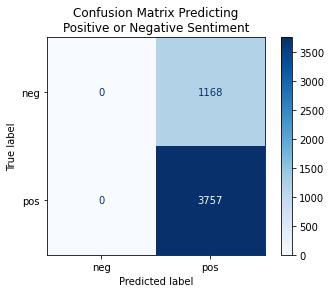

In [ ]:
plot_confusion_matrix(logreg_t, Z_test_t, y_test_t, cmap = 'Blues', values_format = 'd');
plt.title("Confusion Matrix Predicting\nPositive or Negative Sentiment", fontsize=12)

> This confusion matrix using scaled data and logistic regression shows that the model had difficulty with specificity. It was not able to accurately predict negative sentiment in the twitter data with 1168 false positive predictions. In fact, with the baseline data of 0.76 positive sentiments, this model though it was better to simply predict all positive sentiments and 0 negative sentiments. By predicting only positive values, this model accounted for 0.76 of the data.

In [ ]:
pred_proba_t = [i[1] for i in logreg_t.predict_proba(Z_test_t)]

pred_df_t = pd.DataFrame({'true_values': y_test_t,
                        'pred_probs':pred_proba_t})

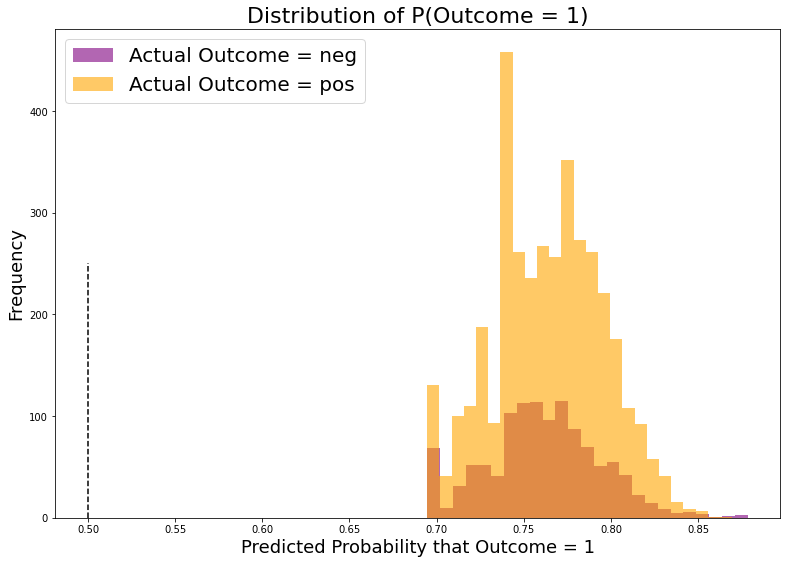

In [ ]:
# Code adapted from global lect: Classification Metrics II

# Create figure.
plt.figure(figsize = (13,9))

# Create two histograms of observations.
plt.hist(pred_df_t[pred_df_t['true_values'] == 'neg']['pred_probs'],
         bins=25,
         color='purple',
         alpha = 0.6,
         label='Actual Outcome = neg')
plt.hist(pred_df_t[pred_df_t['true_values'] == 'pos']['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = pos')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 250,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

## RandomForest Classifier with Twitter

In [ ]:
params_rf_t = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 4, 6]
}

grid_rf_t = GridSearchCV(RandomForestClassifier(),
                        params_rf_t,
                        cv = 5,
                        verbose = 1)


In [ ]:
grid_rf_t.fit(Z_train_t, y_train_t)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [ ]:
grid_rf_t.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}

In [ ]:
grid_rf_t.score(Z_train_t, y_train_t), grid_rf_t.score(Z_test_t, y_test_t)

(0.7628426395939086, 0.7628426395939086)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix Predicting\nPositive or Negative Sentiment')

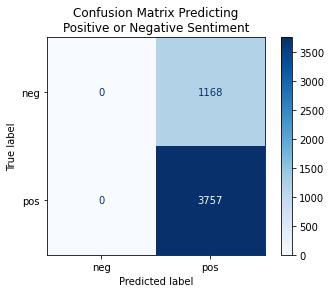

In [ ]:
plot_confusion_matrix(grid_rf_t, Z_test_t, y_test_t, cmap = 'Blues', values_format = 'd');
plt.title("Confusion Matrix Predicting\nPositive or Negative Sentiment", fontsize=12)

> This confusion matrix using scaled data and random forest classifier shows that the model had difficulty with specificity. It was not able to accurately predict negative sentiment in the twitter data with 1168 false positive predictions. In fact, with the baseline data of 0.76 positive sentiments, this model though it was better to simply predict all positive sentiments and 0 negative sentiments. By predicting only positive values, this model accounted for 0.76 of the data.

In [ ]:
# Code adapted from global lect: Classification Metrics II

pred_proba_rf_t = [i[1] for i in grid_rf_t.predict_proba(Z_test_t)]

pred_df_rf_t = pd.DataFrame({'true_values': y_test_t,
                        'pred_probs':pred_proba_rf_t})

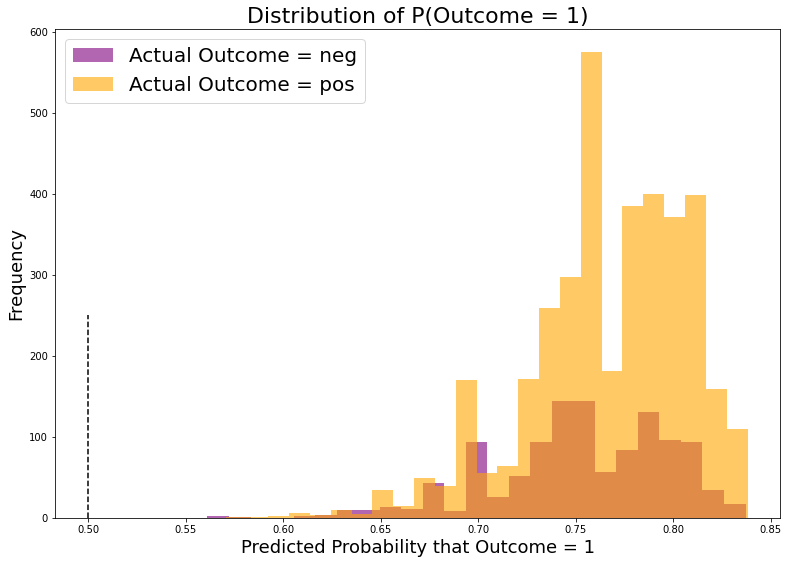

In [ ]:
# Code adapted from global lect: Classification Metrics II

# Create figure.
plt.figure(figsize = (13,9))

# Create two histograms of observations.
plt.hist(pred_df_rf_t[pred_df_rf_t['true_values'] == 'neg']['pred_probs'],
         bins=25,
         color='purple',
         alpha = 0.6,
         label='Actual Outcome = neg')
plt.hist(pred_df_rf_t[pred_df_rf_t['true_values'] == 'pos']['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = pos')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 250,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

## Predicting Death Totals with Twitter Data

### Linear Regression Twitter

In [ ]:
X2_t = twitter.drop(columns = ['text', 'death_tot', 'pos_or_neg_sent'])
y2_t = twitter['death_tot']

In [ ]:
X_train2_t, X_test2_t, y_train2_t, y_test2_t = train_test_split(X2_t, y2_t, random_state = 3000)

In [ ]:
ss2_t = StandardScaler()

Z_train2_t = ss2_t.fit_transform(X_train2_t)
Z_test2_t = ss2_t.transform(X_test2_t)

In [ ]:
linreg_t = LinearRegression()

linreg_t.fit(Z_train2_t, y_train2_t)

LinearRegression()

In [ ]:
linreg_t.score(Z_train2_t, y_train2_t), linreg.score(Z_test2_t, y_test2_t)

(0.9803303966628729, 0.9542964304432938)

> Linear regression was used to predict the death totals from each post using sentiment scores, policy data, and other health data like the number of tests positive as features. With this data, the model was able to predict death totals with an R^2 score of 0.95. This model was just slightly overfit.

# Recommendations and Conclusions

COVID-19 continues to evolve as more information is gathered and new policies are set in place. A lot of the information gather can be used in various ways for EDA and data visualization purposes. The models were not able to predict sentiments based on health and policy data with a high accuracy score. However, the models were able to predict total deaths using sentiments, health, and policy data with high $R^2$ scores. Further exploration into the data is recommended. Some recommendations and next steps for the continuation of this project include, but are not limited to, exploring data prior to July 2020 as well as in future months, analysing the policy information by state, further exploring correlation between health and policy mandates, and deeper exploration between the correlation of sentiment scores and policy information. Additionally, Reddit and Twitter were the only social media platforms assessed in the project. Future projects may find it beneficial to explore other social media platforms.